# Setup of Colab Environment
---

Every Colab runs it's own instance on cloud. We need setup workshop enviroment in those steps:  
* Setup GPU instance: Runtime ->  Change runtime type 
* Install workshop package with all requiremetns from git
* Import all packages
* Mount GDrive  

In [ ]:
!pip install git+https://github.com/adamoz/colab_image_processing_workshop_torch.git

In [ ]:
!pip uninstall tensorboard-plugin-wit

In [ ]:
# Basic tools
from image_processing_workshop.utils import get_image_from_url
from collections import deque
from google.colab import drive
from google.colab import files
from shutil import rmtree
import tqdm
import pandas as pd
import numpy as np
import torch
import os

# Datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor
from torchvision.datasets import FashionMNIST

# Architecture of NN
from torch import nn
import torch.nn.functional as F
from torch.nn import Module, Sequential
from torch.nn import ReLU, Tanh, Dropout, Softmax, Linear, BatchNorm1d, Conv2d, MaxPool2d, BatchNorm2d
from torch.nn.init import xavier_uniform_, normal_

# Training
from torch.nn import MSELoss, CrossEntropyLoss, NLLLoss
from torch.optim import Adam, SGD

# Metrics
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.eval import get_precision
from image_processing_workshop.eval import get_recall
from image_processing_workshop.eval import get_rec_prec
from image_processing_workshop.eval import get_accuracy
from image_processing_workshop.eval import get_false_positives

# Visualization
import matplotlib.pyplot as plt
from image_processing_workshop.visual import plot_classify, plot_image
from image_processing_workshop.visual import plot_df_examples
from image_processing_workshop.visual import plot_coocurance_matrix
from ipywidgets import interactive
import ipywidgets as ipw
from torch.utils.tensorboard import SummaryWriter


In [ ]:
drive.mount('./drive', force_remount=True)

In [ ]:
os.listdir('./drive/My Drive/')

# Work with PyTorch Datasets
---

## Custom dataset

### Creating of dataset
PyTorch provides easy mechanism to work with datasets. You just need to inherit from `torch.utils.data.Dataset` and override 2 methods:
 - `__len__` in a way that len(dataset) returns the size of the dataset.
 - `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample

In [ ]:
class LetterDataset(Dataset):
    """A-F Letter dataset."""
    
    def __init__(self, transform=None):
        """
        Args:
            transform (callable, optional): Optional transformation to be applied on a sample.
        """
        self.raw_data = ['A', 'B', 'C', 'D', 'E', 'F']
        self.transform = transform
        
    def __len__(self):
        return len(self.raw_data)
    
    def __getitem__(self, idx):
        sample = {'letter': self.raw_data[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
letter_dataset = LetterDataset()

In [ ]:
len(letter_dataset)

6

In [ ]:
letter_dataset[5]

{'letter': 'F'}

### Apply transformations to dataset
We can create objects with `__call__` method applying transforamtions to data from dataset. To put more transformations together, we can use `torchvision.transforms.Compose`. PyTorch provides multiple prepared  image transformations in `torchvision.transforms`.

In [ ]:
class ToLower(object):
    def __call__(self, sample):
        return {'letter': sample['letter'].lower()}

class JoinX(object):
    def __call__(self, sample):
        return {'letter': sample['letter'] + 'X'}

In [ ]:
transformations = Compose([ToLower(), JoinX()])

In [ ]:
letter_dataset = LetterDataset(transform=transformations)
letter_dataset[5]

{'letter': 'fX'}

### Sampling batches from dataset
PyTorch provides iterator `torch.utils.data.DataLoader` for work with datasets based on `torch.utils.data.Dataset` class.   
It enables
 - batching the data
 - shuffling the data  
 - load the data in parallel manner using multiprocessing workers


In [ ]:
data_loader = DataLoader(dataset=letter_dataset, batch_size=3, num_workers=1, shuffle=True)

In [ ]:
next(iter(data_loader))

{'letter': ['bX', 'cX', 'dX']}

## Explore prepared dataset Fashion MNIST

In [ ]:
transformations = transforms.Compose([transforms.ToTensor()])

### Training data

In [ ]:
train_dataset = datasets.FashionMNIST('./drive/My Drive/ml_college_data/dataset_fashion_mnist/', download=True, train=True, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [ ]:
train_dataset.class_to_idx

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

In [ ]:
len(train_dataset)

60000

In [ ]:
train_dataset[0]

In [ ]:
next(iter(train_loader))

<Figure size 432x288 with 0 Axes>

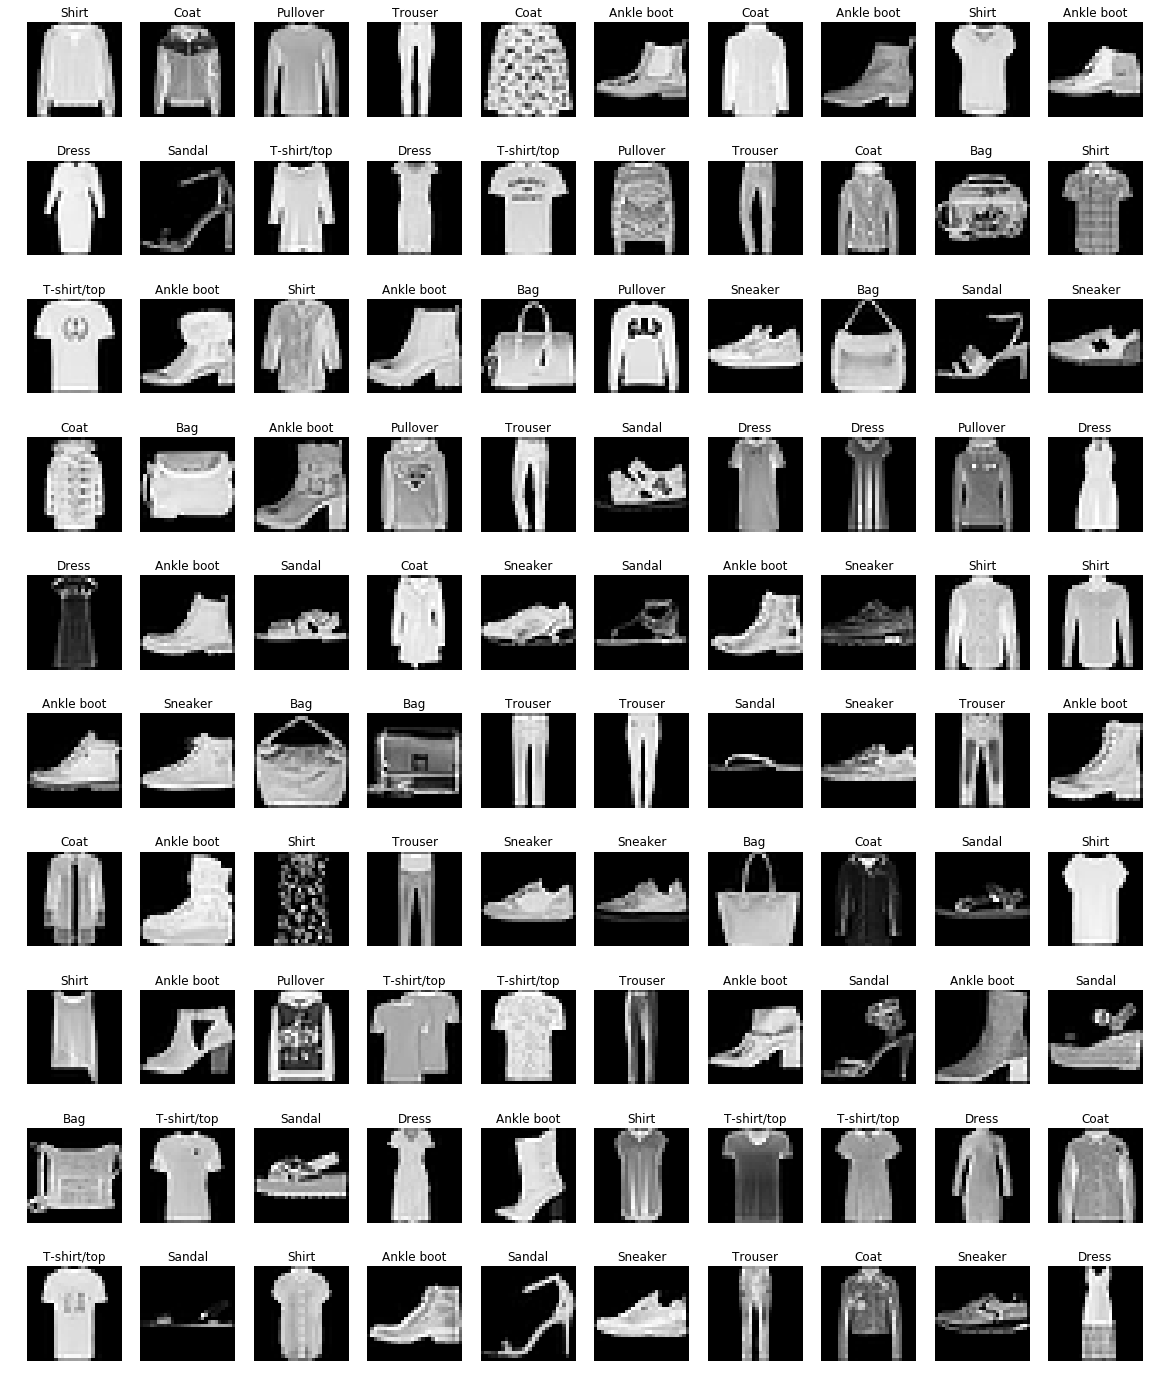

In [ ]:
plt.subplots_adjust(wspace=1.5, hspace=2.5)
fig = plt.figure(figsize=(20,25))

img_batch, label_batch = next(iter(train_loader))
img_batch = img_batch.squeeze(dim=1).numpy()
label_batch = label_batch.numpy()
for img_id in range(100):
    ax = plt.subplot(10, 10, img_id+1)
    img = img_batch[img_id]
    
    class_id = label_batch[img_id]
    class_name = train_dataset.classes[class_id]
    ax.imshow(img , cmap='gray')
    ax.set_title(class_name)
    ax.axes.set_axis_off()

### Validation data

In [ ]:
valid_dataset = datasets.FashionMNIST('./drive/My Drive/ml_college_data/dataset_fashion_mnist/', download=True, train=False, transform=transformations)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
len(valid_dataset)

10000

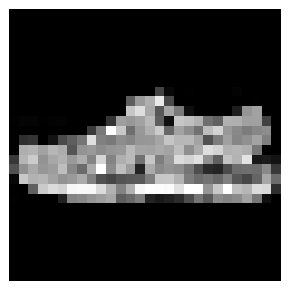

In [ ]:
plot_image(valid_dataset[21][0], figsize=(5, 5))

In [ ]:
labels = valid_dataset.targets
class_names = list(map(lambda class_id: valid_dataset.classes[class_id], labels))
df = pd.DataFrame({'class_names': class_names, 'class_ids': labels})
df.head(10)

class_names  class_ids
0  Ankle boot          9
1    Pullover          2
2     Trouser          1
3     Trouser          1
4       Shirt          6
5     Trouser          1
6        Coat          4
7       Shirt          6
8      Sandal          5
9     Sneaker          7

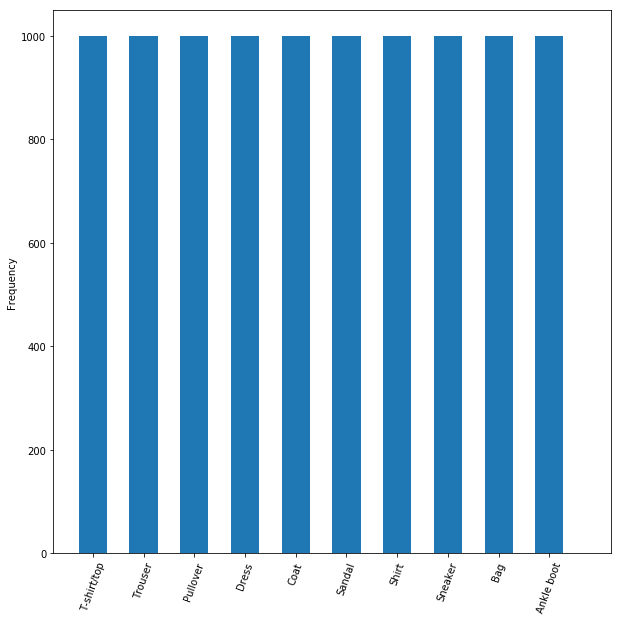

In [ ]:
fig = plt.figure(figsize=(10, 10))
df.loc[:,'class_ids'].plot(kind='hist', width=0.5)
ax = plt.gca()
ax_ticks = ax.xaxis.set_ticks(np.arange(0.25, 9, 0.9))
ax_labels = ax.xaxis.set_ticklabels(list(valid_dataset.classes), rotation=70)

# Feed Forward Neural Network on Fashion MNIST
---

## Prepare Fashion MNIST dataset
We want to preprocess training data, specifically to have flatten shape `(28, 28) -> 784` in `torch.Tensor` format.

In [ ]:
class FlattenTransform:
    def __call__(self, sample):
        return sample.reshape(-1)

In [ ]:
transformations = Compose([ToTensor(), FlattenTransform()])

In [ ]:
train_dataset = FashionMNIST('./drive/My Drive/ml_college_data/dataset_fashion_mnist/', download=True, train=True, transform=transformations, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

valid_dataset = FashionMNIST('./drive/My Drive/ml_college_data/dataset_fashion_mnist/', download=True, train=False, transform=transformations, target_transform=None)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
train_dataset[0]

In [ ]:
next(iter(train_loader))

## Define feed forward neural network
**Important:** Don't forget to setup `.eval()` or `.train()` modes for model to enforce proper behaviour of certain layers as `torch.nn.Dropout` or `torch.nn.BatchNorm1d`.

### Architecture

In [ ]:
class FeedForwardNeuralNet(torch.nn.Module):
    def __init__(self):
        super(FeedForwardNeuralNet, self).__init__()
        
        self.layer_1 = Linear(784, 64)
        self.layer_2 = Linear(64, 10)
        xavier_uniform_(self.layer_1.weight)
        
        self.batch_norm_layer_1 = BatchNorm1d(64)
        self.dropout = Dropout(p=0.1)

        
    def forward(self, input_batch):
        prediction = self.layer_1(input_batch)
        prediction = torch.relu(prediction)
        prediction = self.batch_norm_layer_1(prediction)
        prediction = self.dropout(prediction)
        prediction = self.layer_2(prediction)
        return torch.softmax(prediction, dim=1)
        # return torch.log_softmax(prediction, dim=1) -> torch.exp(prediction)

In [ ]:
feed_forward_neural_net = FeedForwardNeuralNet()

In [ ]:
feed_forward_neural_net

FeedForwardNeuralNet(
  (layer_1): Linear(in_features=784, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=10, bias=True)
  (batch_norm_layer_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
feed_forward_neural_net.state_dict()

In [ ]:
images, labels = next(iter(valid_loader))

In [ ]:
feed_forward_neural_net.eval()
predictions = feed_forward_neural_net(images)
feed_forward_neural_net.train()
predictions[:4]

tensor([[0.1246, 0.1138, 0.0907, 0.0716, 0.0985, 0.0771, 0.0888, 0.1012, 0.1127,
         0.1208],
        [0.1720, 0.1031, 0.0985, 0.0453, 0.1173, 0.0474, 0.1007, 0.0852, 0.1018,
         0.1287],
        [0.1166, 0.0863, 0.0905, 0.0815, 0.1051, 0.0840, 0.1158, 0.0962, 0.1106,
         0.1133],
        [0.1033, 0.0859, 0.0779, 0.0835, 0.1071, 0.0966, 0.1040, 0.1262, 0.0955,
         0.1200]], grad_fn=<SliceBackward>)

In [ ]:
torch.cuda.current_device()

0

In [ ]:
feed_forward_neural_net = feed_forward_neural_net.cuda()
images = images.cuda()
labels = labels.cuda()

In [ ]:
feed_forward_neural_net.eval()
predictions = feed_forward_neural_net(images)
feed_forward_neural_net.train()
predictions[:4]

tensor([[0.1246, 0.1138, 0.0907, 0.0716, 0.0985, 0.0771, 0.0888, 0.1012, 0.1127,
         0.1208],
        [0.1720, 0.1031, 0.0985, 0.0453, 0.1173, 0.0474, 0.1007, 0.0852, 0.1018,
         0.1287],
        [0.1166, 0.0863, 0.0905, 0.0815, 0.1051, 0.0840, 0.1158, 0.0962, 0.1106,
         0.1133],
        [0.1033, 0.0859, 0.0779, 0.0835, 0.1071, 0.0966, 0.1040, 0.1262, 0.0955,
         0.1200]], device='cuda:0', grad_fn=<SliceBackward>)

### Optimizers and loss function

In [ ]:
loss_fce = CrossEntropyLoss()
loss_fce

CrossEntropyLoss()

In [ ]:
loss_fce(predictions, labels)

tensor(2.3021, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
#optimizer = SGD(feed_forward_neural_net.parameters(), lr=0.1)
optimizer = Adam(feed_forward_neural_net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## Training of neural net

In [ ]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    
    model.eval()
    for images, labels in valid_loader:
        images = images.cuda()
        labels = labels.cuda()
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [ ]:
get_valid_acc_and_loss(feed_forward_neural_net, loss_fce, valid_loader)

(3.4434713375796178, 2.3024783772268114)

In [ ]:
# Initial params setup.
epochs = 2
report_period = 100
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [ ]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    feed_forward_neural_net.train()
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        batch_iteration += 1
        
        ##################
        # Training Phase #
        ##################
        optimizer.zero_grad()
        predictions = feed_forward_neural_net.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()
        
        ####################
        # Validation Phase #
        ####################
        train_leak_loss.append(loss.item())
        if batch_iteration % report_period == 0:
            feed_forward_neural_net.eval()
            
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(feed_forward_neural_net, loss_fce, valid_loader)
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                   
            feed_forward_neural_net.train()

Epoch: 1/2..  Train Loss: 1.87..  Valid Loss: 1.75..  Valid Acc: 76.71%
Epoch: 1/2..  Train Loss: 1.72..  Valid Loss: 1.69..  Valid Acc: 80.69%
Epoch: 1/2..  Train Loss: 1.68..  Valid Loss: 1.68..  Valid Acc: 80.16%
Epoch: 1/2..  Train Loss: 1.66..  Valid Loss: 1.66..  Valid Acc: 82.67%
Epoch: 1/2..  Train Loss: 1.65..  Valid Loss: 1.65..  Valid Acc: 82.96%
Epoch: 1/2..  Train Loss: 1.64..  Valid Loss: 1.66..  Valid Acc: 81.49%
Epoch: 1/2..  Train Loss: 1.63..  Valid Loss: 1.65..  Valid Acc: 82.66%
Epoch: 1/2..  Train Loss: 1.64..  Valid Loss: 1.64..  Valid Acc: 83.76%
Epoch: 1/2..  Train Loss: 1.63..  Valid Loss: 1.64..  Valid Acc: 83.77%
Epoch: 2/2..  Train Loss: 1.64..  Valid Loss: 1.65..  Valid Acc: 82.89%
Epoch: 2/2..  Train Loss: 1.62..  Valid Loss: 1.63..  Valid Acc: 84.07%
Epoch: 2/2..  Train Loss: 1.62..  Valid Loss: 1.63..  Valid Acc: 84.06%
Epoch: 2/2..  Train Loss: 1.62..  Valid Loss: 1.62..  Valid Acc: 84.52%
Epoch: 2/2..  Train Loss: 1.62..  Valid Loss: 1.63..  Valid Acc:

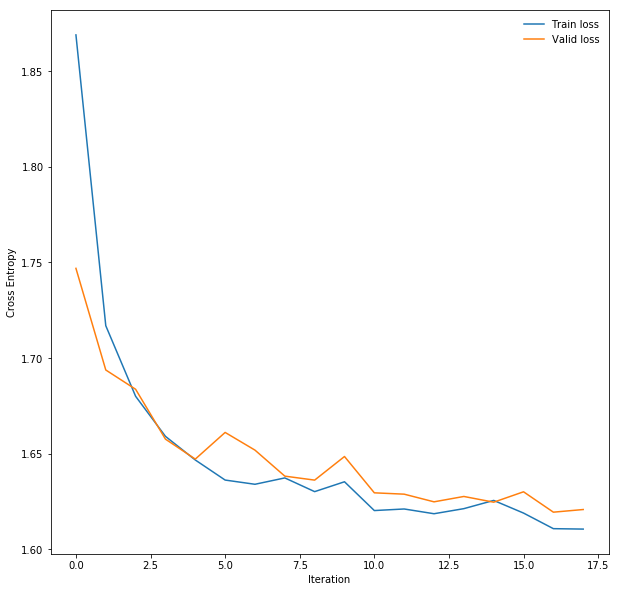

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

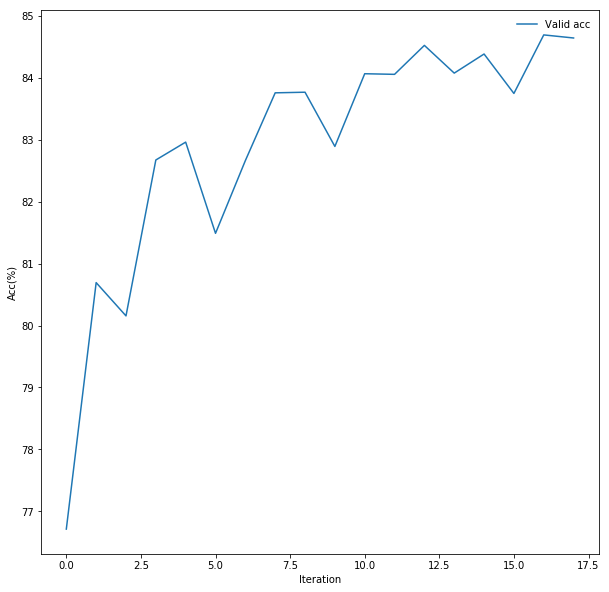

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

---

## Results evaluation

In [ ]:
feed_forward_neural_net.eval()
feed_forward_neural_net = feed_forward_neural_net.cpu()

FeedForwardNeuralNet(
  (layer_1): Linear(in_features=784, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=10, bias=True)
  (batch_norm_layer_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

### View single images and predictions

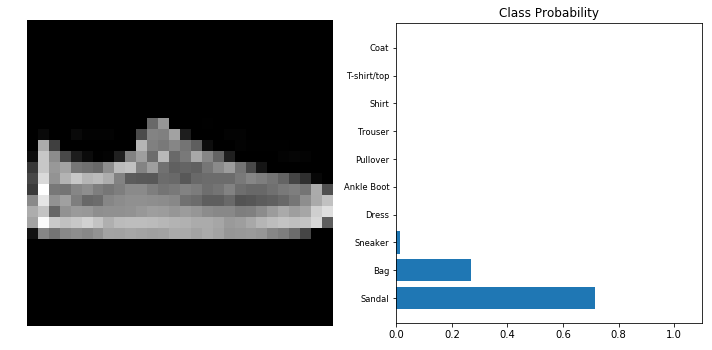

In [ ]:
plot_classify(input_tensor=valid_dataset[12][0], 
              model=feed_forward_neural_net, image_shape=[28,28])

### Load reuslts to pandas df

In [ ]:
df = get_results_df(feed_forward_neural_net, valid_loader)
df.head(10)

label_class_name  ...                                              image
0       Ankle boot  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1         Pullover  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2          Trouser  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003...
3          Trouser  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4            Shirt  ...  [0.0, 0.0, 0.0, 0.007843137718737125, 0.0, 0.0...
5          Trouser  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6             Coat  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003...
7            Shirt  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007...
8           Sandal  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9          Sneaker  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[10 rows x 5 columns]

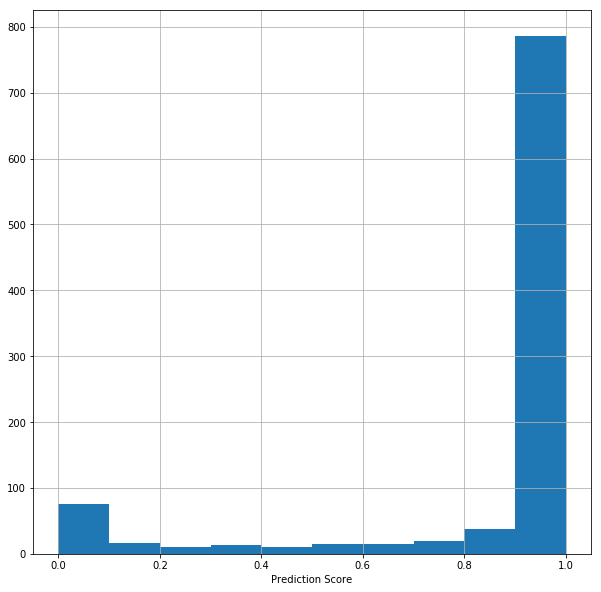

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='Dress'].label_class_score.hist(ax=ax)

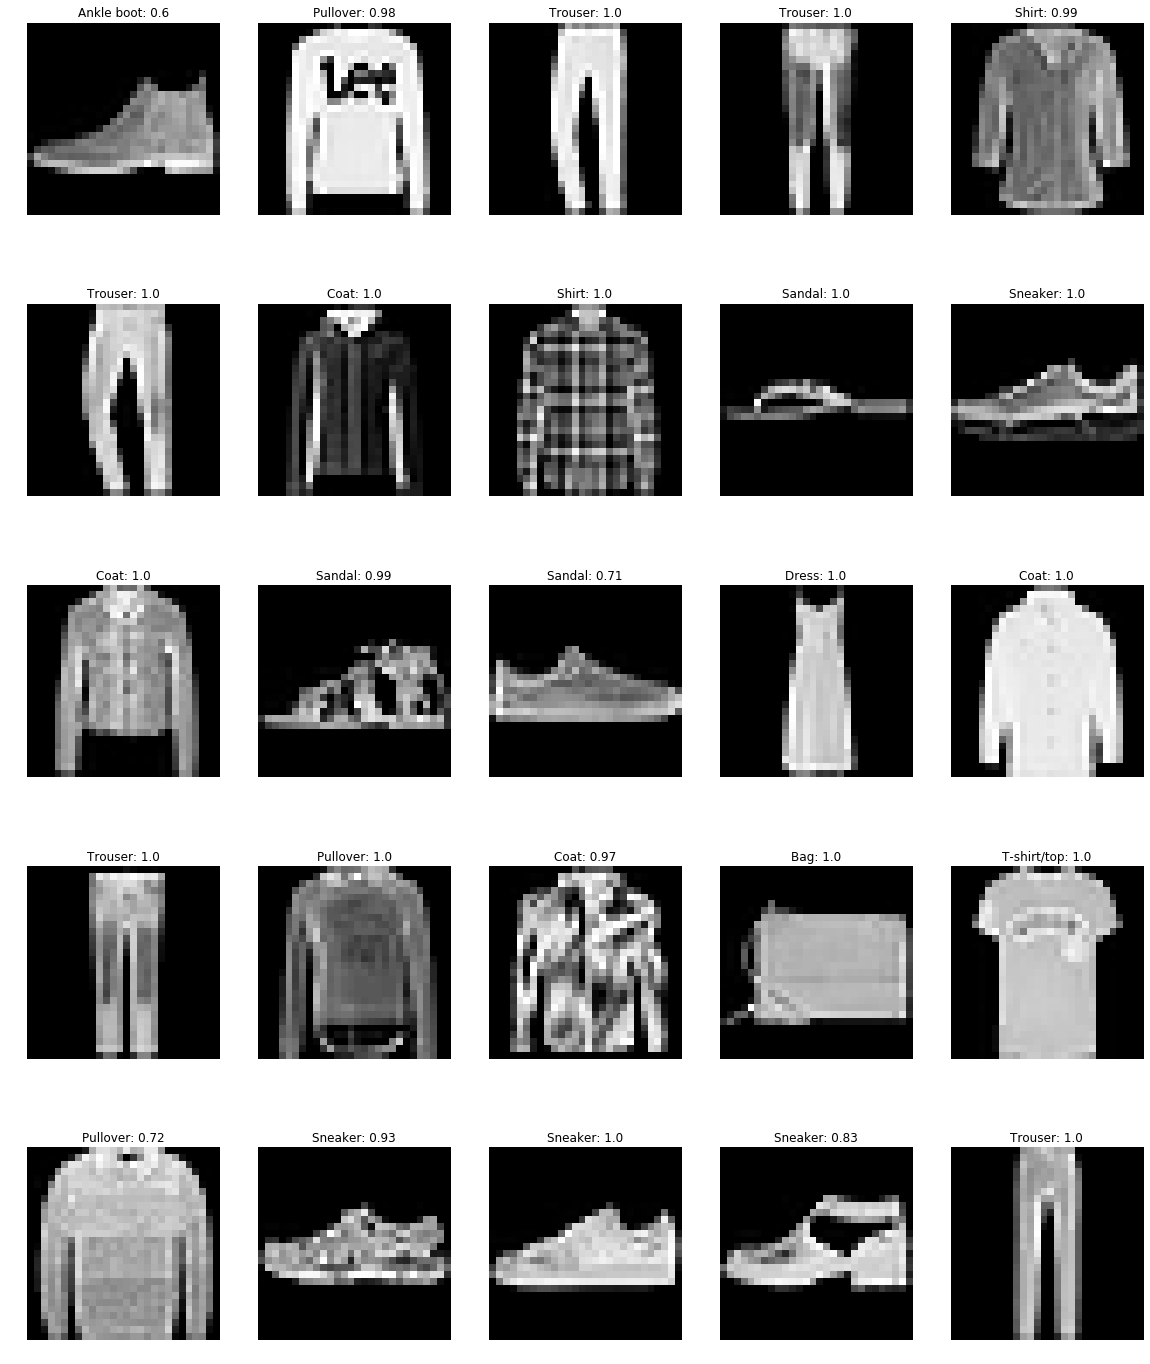

In [ ]:
plot_df_examples(df.iloc[:25], image_shape=[28, 28])

### Basic Metrics

In [ ]:
get_precision(df, 'Dress')

83.15

In [ ]:
get_recall(df, 'Dress')

88.3

In [ ]:
get_rec_prec(df)

class_name  recall  precision
0  T-shirt/top    84.4      77.86
1      Trouser    96.1      97.66
2     Pullover    62.6      82.69
3        Dress    88.3      83.15
4         Coat    85.4      66.56
5       Sandal    91.2      96.20
6        Shirt    52.1      66.79
7      Sneaker    95.6      87.95
8          Bag    97.2      93.01
9   Ankle boot    92.5      95.36

In [ ]:
get_accuracy(df)

84.54

### False Positives

In [ ]:
fp = get_false_positives(df, label_class_name='Shirt')

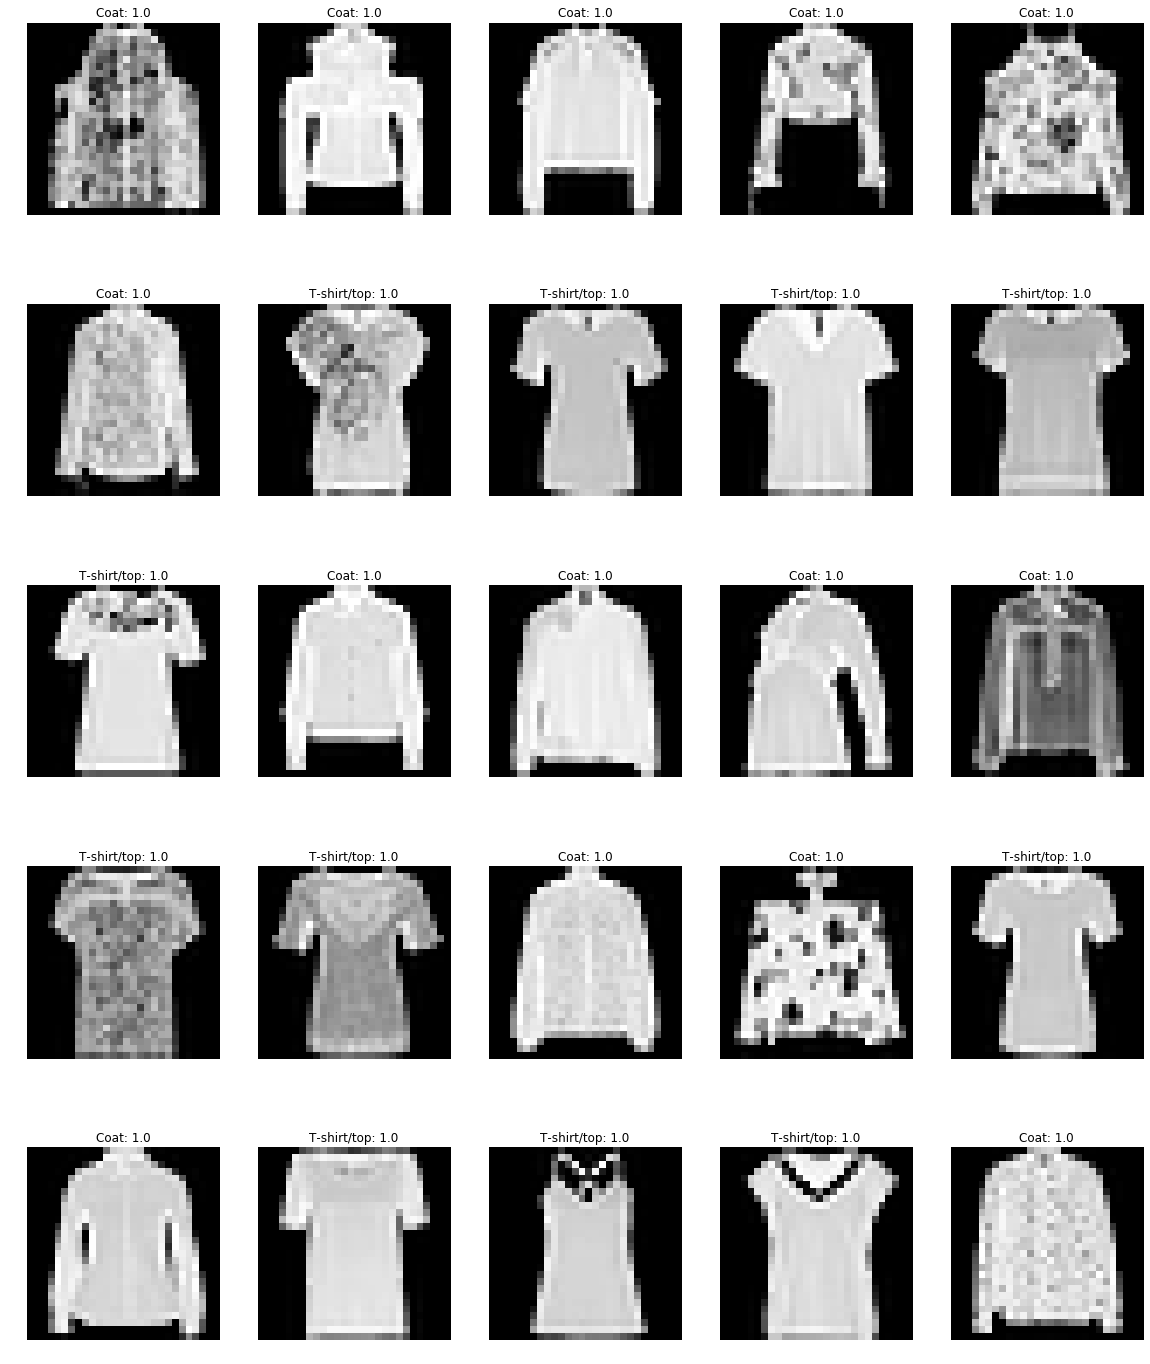

In [ ]:
plot_df_examples(fp, image_shape=[28, 28])

In [ ]:
fp = get_false_positives(df, label_class_name='Shirt', predicted_class_name='Pullover')

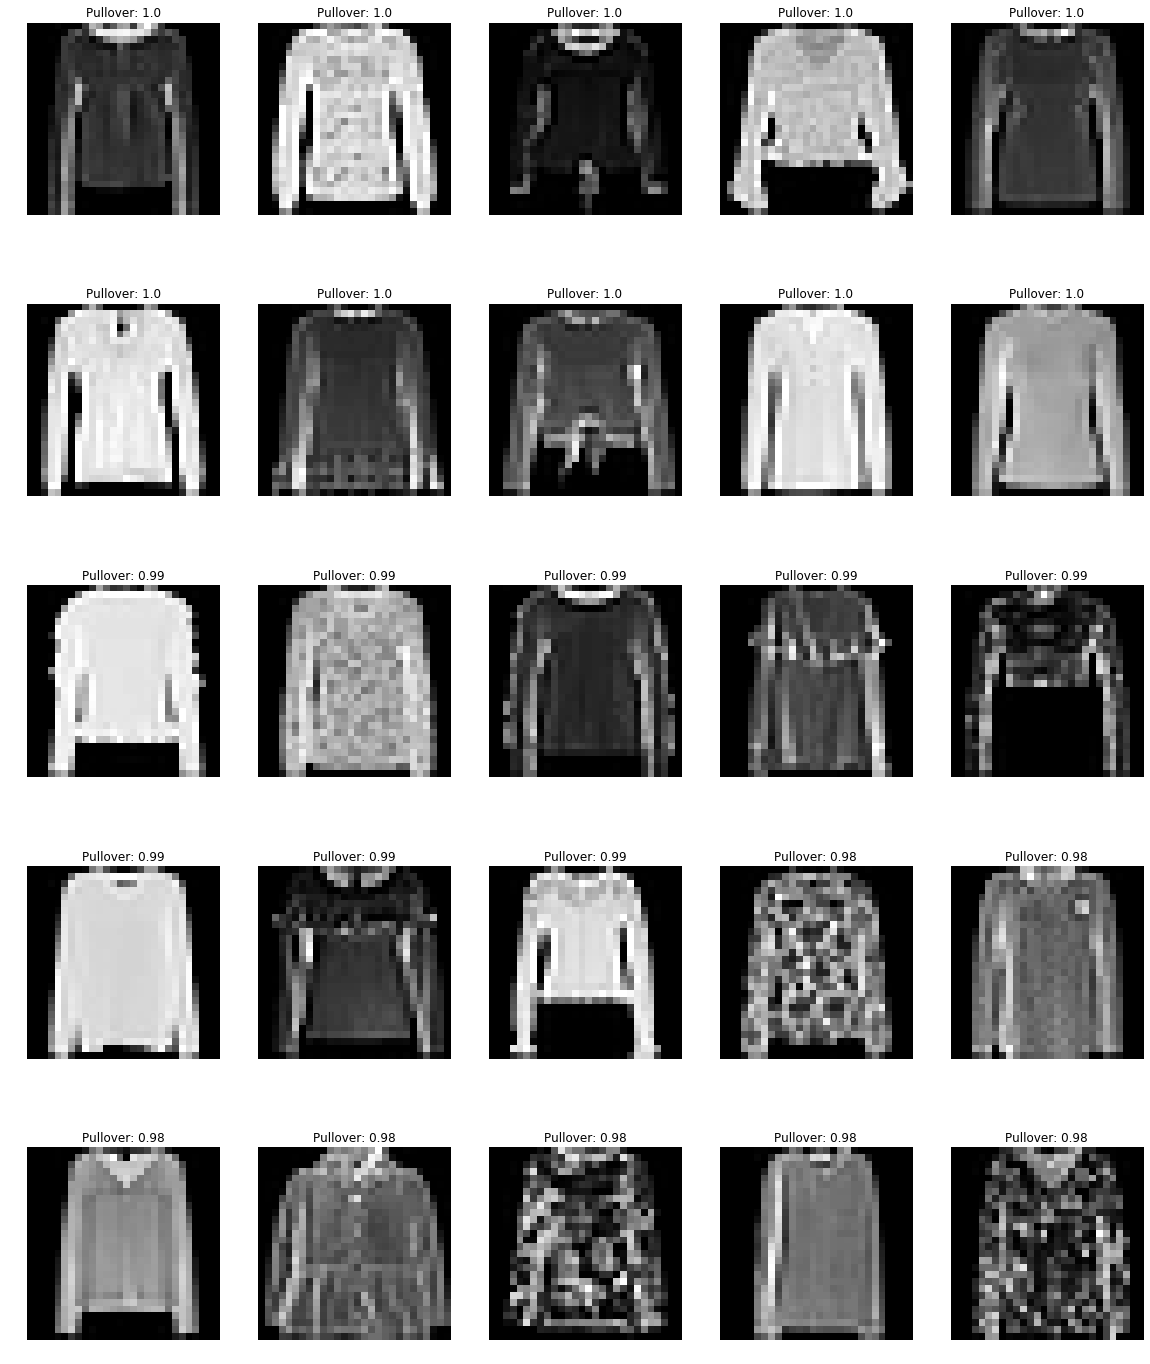

In [ ]:
plot_df_examples(fp, image_shape=[28, 28])

### Confusion Matrix

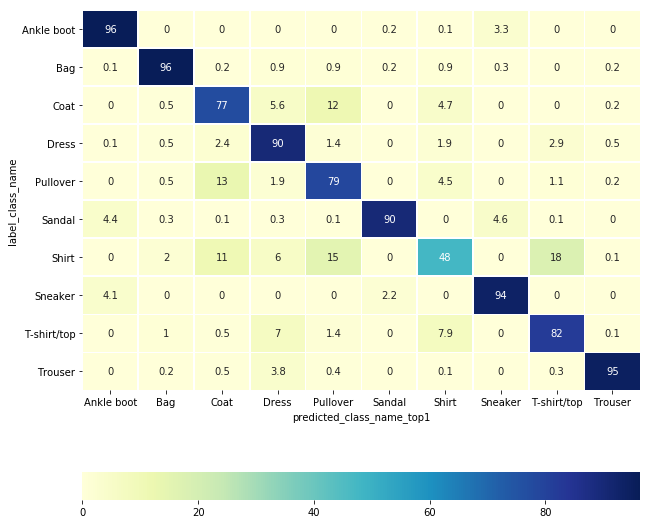

In [ ]:
plot_coocurance_matrix(df, use_log=False)

# Convolutional Neural Network on Fashion MNIST
---

## Intro to convolutional filters

### Download your favouirite image

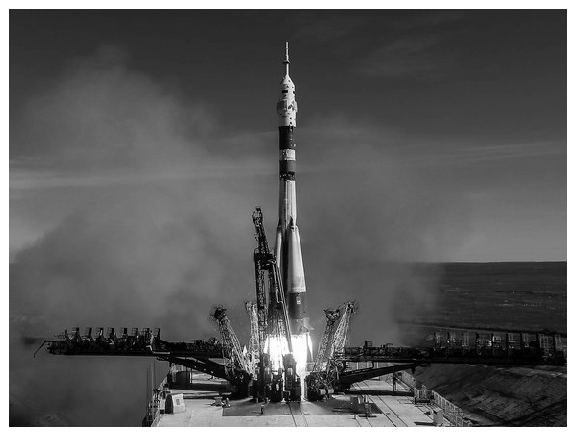

In [ ]:
url = 'https://media.wired.com/photos/5bbf72c46278de2d2123485b/master/w_582,c_limit/soyuz-1051882240.jpg'
img = get_image_from_url(url, to_grayscale=True)
img = img / 255.
plot_image(img)

### Explore prepared filters

In [ ]:
initial_filter = np.array([[-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1], 
                           [-1, -1, 1, 1]])
filter_1 = initial_filter
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3
filters = np.array([filter_1, filter_2, filter_3, filter_4])

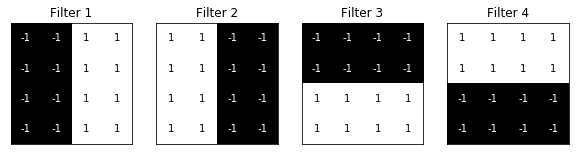

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    
    # Add -1 1 annotations to image.
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')

### Build small network initialised with those filters
In the examples, we will use `torch.nn.conv2d` https://pytorch.org/docs/stable/nn.html#conv2d

In [ ]:
filters_torch = torch.from_numpy(filters).unsqueeze(1).type(torch.DoubleTensor)
filters_torch.shape

torch.Size([4, 1, 4, 4])

In [ ]:
img_torch = torch.from_numpy(img).unsqueeze(0).unsqueeze(1)
img_torch.shape

torch.Size([1, 1, 436, 582])

Convoluton filters efectively change height and width of input image that

$H_{out} = \lfloor \frac{H_{in}+2×padding[0]−dilation[0]×(kernel\_size[0]−1)−1}{stride[0]} +1 \rfloor$   
$W_{out} = \lfloor \frac{W_{in}+2×padding[1]−dilation[1]×(kernel\_size[1]−1)−1}{stride[1]} +1 \rfloor$



In [ ]:
class ConvNeuralNetSimple(nn.Module):    
    def __init__(self, filters_torch):
        super(ConvNeuralNetSimple, self).__init__()
        
        height, width = filters_torch.shape[2:]
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=4, 
                                    kernel_size=(height, width), bias=False)
        self.conv_layer.weight.data = filters_torch

    def forward(self, images):
        return self.conv_layer(images)
    
conv_neural_net_simple = ConvNeuralNetSimple(filters_torch)
conv_neural_net_simple

ConvNeuralNetSimple(
  (conv_layer): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [ ]:
img_torch.shape

torch.Size([1, 1, 436, 582])

In [ ]:
feature_maps = conv_neural_net_simple(img_torch)
feature_maps.shape

torch.Size([1, 4, 433, 579])

### Visualization of conv layer feature maps

In [ ]:
def vizualize_feature_maps(feature_maps, n_maps= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_maps):
        ax = fig.add_subplot(1, n_maps, i+1, xticks=[], yticks=[])
        # grab layer outputs
        ax.imshow(np.squeeze(feature_maps[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

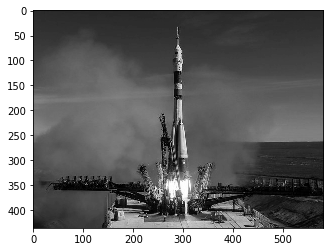

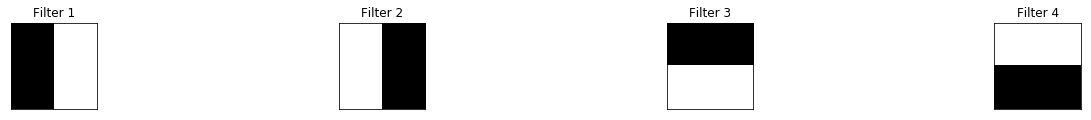

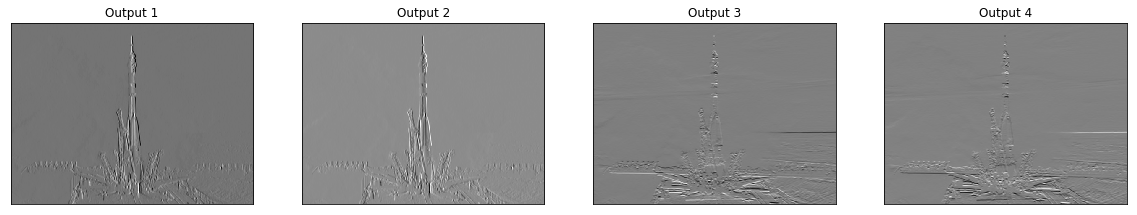

In [ ]:
# Source img.
plt.imshow(img, cmap='gray')

# Convolution filters.
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

# Feature maps.    
vizualize_feature_maps(feature_maps)

### Sensitivity of image on convolution filters

In [ ]:
feature_map = feature_maps[0][0].detach().numpy()
feature_map.shape

(433, 579)

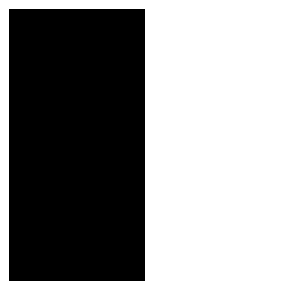

In [ ]:
plot_image(filter_1, figsize=(5,5))

In [ ]:
feature_map_max = feature_map.max()
def plot_sensitivity(tolerance):
    feature_map_filtered = (feature_map >= (feature_map_max - tolerance)).astype(int)
    fig = plt.figure(figsize=(10, 10))
    im = plt.imshow(feature_map_filtered, cmap='gray')
    plt.colorbar(im, orientation='horizontal')
    plt.gca().axes.set_axis_off()
    plt.show()
    
interactive(plot_sensitivity, tolerance=ipw.FloatSlider(0.5, min=0, max=feature_map_max - 0.1, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='tolerance', max=5.456862745098039, step=0.01), Outpu…

## Prepare Fashion MNIST dataset

In [ ]:
transformations = Compose([ToTensor()])

train_dataset = FashionMNIST('./drive/My Drive/ml_college_data/dataset_fashion_mnist/', download=True, train=True, transform=transformations, target_transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset = FashionMNIST('./drive/My Drive/ml_college_data/dataset_fashion_mnist/', download=True, train=False, transform=transformations, target_transform=None)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
valid_dataset[0][0].shape

torch.Size([1, 28, 28])

## Define convolutional neural network

### Architecure

In [ ]:
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.use_softmax = False
        # Variables for logging of layers shapes.
        self.shape_conv1 = None
        self.shape_conv2 = None

        # 1st segment of conv with batch norm and pooling.
        self.conv1 = nn.Sequential(
            Conv2d(1, 32, (3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(),
            BatchNorm2d(32),
            MaxPool2d((2, 2), stride=(2, 2)))
        
        # 2nd segment of conv with batch norm and pooling.
        self.conv2 = nn.Sequential(
            Conv2d(32, 64, (3, 3), stride=(1, 1), padding=(1, 1)),
            ReLU(),
            BatchNorm2d(64),
            MaxPool2d((2, 2), stride=(2, 2)))
        
        # Linear output.
        self.linear = Linear(7*7*64, 10)

    def forward(self, images):
        x = self.conv1(images)
        self.shape_conv1 = x.shape
        
        x = self.conv2(x)
        self.shape_conv2 = x.shape

        
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        #return torch.softmax(x, dim=1) # -> CrossEntropyLoss
        x = torch.log_softmax(x, dim=1) # -> NLLLoss
        if self.use_softmax:
            return torch.exp(x)
        else:
            return x

conv_neural_net = ConvNeuralNet()
conv_neural_net

ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=3136, out_features=10, bias=True)
)

In [ ]:
valid_dataset[0][0]

In [ ]:
info = conv_neural_net.eval()

In [ ]:
conv_neural_net(valid_dataset[0][0].unsqueeze(0))

tensor([[-2.2475, -2.3651, -2.2378, -2.3249, -2.1843, -2.4025, -2.4323, -2.2610,
         -2.3299, -2.2683]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
conv_neural_net.use_softmax = True
conv_neural_net(valid_dataset[0][0].unsqueeze(0))

tensor([[0.1057, 0.0939, 0.1067, 0.0978, 0.1126, 0.0905, 0.0878, 0.1042, 0.0973,
         0.1035]], grad_fn=<ExpBackward>)

In [ ]:
conv_neural_net.use_softmax = False
info = conv_neural_net.train()

In [ ]:
conv_neural_net.shape_conv1, conv_neural_net.shape_conv2

(torch.Size([1, 32, 14, 14]), torch.Size([1, 64, 7, 7]))

In [ ]:
conv_neural_net = conv_neural_net.cuda()

### Optimizers and loss function
More on loss functions can be found here: https://pytorch.org/docs/stable/nn.html#loss-functions  
More on optimizers can be found here: https://pytorch.org/docs/stable/optim.html

In [ ]:
#loss_fce = CrossEntropyLoss()
loss_fce = NLLLoss()
loss_fce

NLLLoss()

In [ ]:
optimizer = Adam(conv_neural_net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## Train neural net

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    
    model.eval()
    for images, labels in valid_loader:
        images = images.cuda()
        labels = labels.cuda()
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [ ]:
get_valid_acc_and_loss(conv_neural_net, loss_fce, valid_loader)

(9.902468152866243, 2.3091942762872977)

In [ ]:
# Initial params setup.
epochs = 2
report_period = 100
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [ ]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    conv_neural_net.train()
    for images, labels in train_loader:
        batch_iteration += 1
        images = images.cuda()
        labels = labels.cuda()
        
        ##################
        # Training Phase #
        ##################        
        optimizer.zero_grad()
        predictions = conv_neural_net.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()

        ####################
        # Validation Phase #
        ####################
        train_leak_loss.append(loss.item())
        if batch_iteration % report_period == 0:
            conv_neural_net.eval()
            
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(conv_neural_net, loss_fce, valid_loader)
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                   
            conv_neural_net.train()

Epoch: 1/2..  Train Loss: 0.64..  Valid Loss: 0.5..  Valid Acc: 82.08%
Epoch: 1/2..  Train Loss: 0.42..  Valid Loss: 0.4..  Valid Acc: 85.75%
Epoch: 1/2..  Train Loss: 0.39..  Valid Loss: 0.49..  Valid Acc: 82.86%
Epoch: 1/2..  Train Loss: 0.37..  Valid Loss: 0.34..  Valid Acc: 87.58%
Epoch: 1/2..  Train Loss: 0.34..  Valid Loss: 0.34..  Valid Acc: 88.33%
Epoch: 1/2..  Train Loss: 0.32..  Valid Loss: 0.38..  Valid Acc: 87.3%
Epoch: 1/2..  Train Loss: 0.34..  Valid Loss: 0.33..  Valid Acc: 87.84%
Epoch: 1/2..  Train Loss: 0.32..  Valid Loss: 0.32..  Valid Acc: 88.55%
Epoch: 1/2..  Train Loss: 0.3..  Valid Loss: 0.31..  Valid Acc: 88.84%
Epoch: 2/2..  Train Loss: 0.29..  Valid Loss: 0.34..  Valid Acc: 88.53%
Epoch: 2/2..  Train Loss: 0.28..  Valid Loss: 0.29..  Valid Acc: 89.96%
Epoch: 2/2..  Train Loss: 0.27..  Valid Loss: 0.31..  Valid Acc: 89.08%
Epoch: 2/2..  Train Loss: 0.27..  Valid Loss: 0.28..  Valid Acc: 90.38%
Epoch: 2/2..  Train Loss: 0.27..  Valid Loss: 0.32..  Valid Acc: 88.

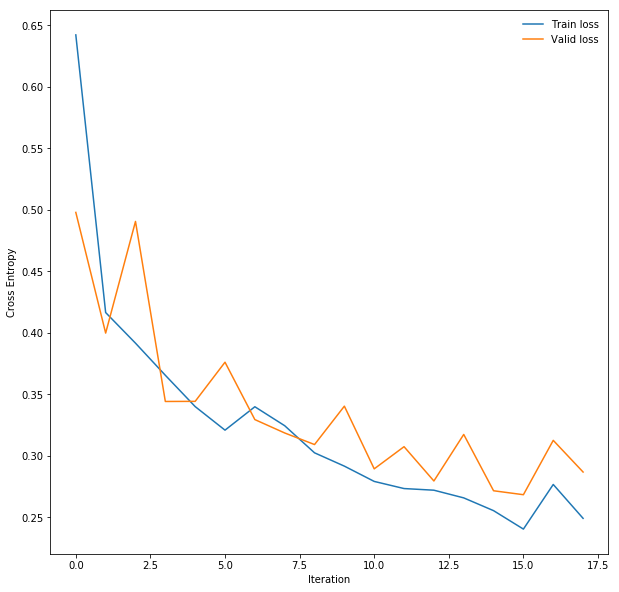

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

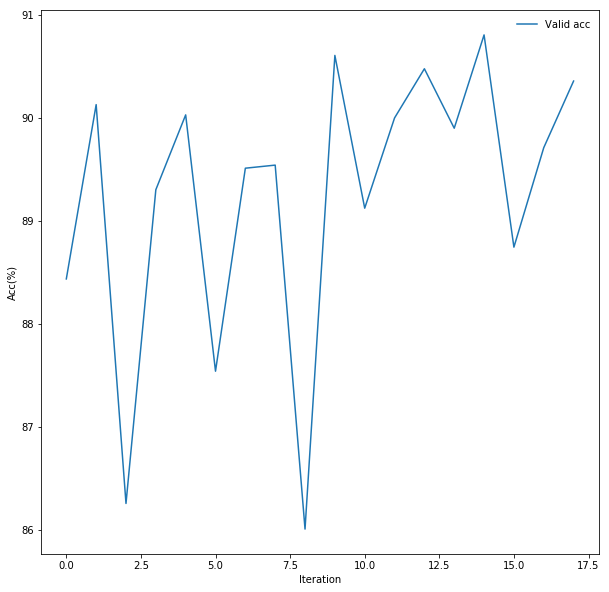

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

## Results evaluation

In [ ]:
conv_neural_net = conv_neural_net.cpu()
conv_neural_net.eval()
conv_neural_net.use_softmax = True

### View single images and predictions

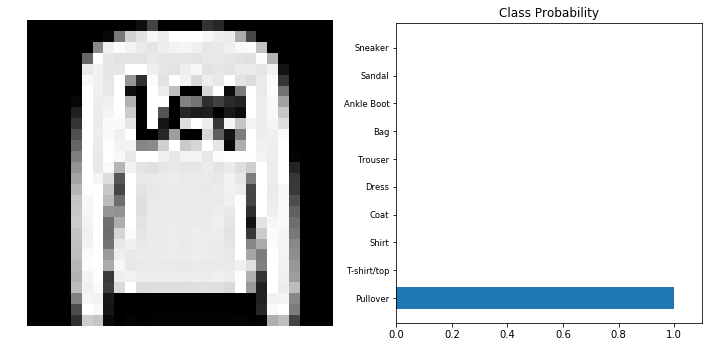

In [ ]:
plot_classify(valid_dataset[1][0], conv_neural_net)

### Load reuslts to pandas df

In [ ]:
df = get_results_df(conv_neural_net, valid_loader)
df.head(10)

label_class_name  ...                                              image
0       Ankle boot  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
1         Pullover  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
2          Trouser  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
3          Trouser  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
4            Shirt  ...  [[[0.0, 0.0, 0.0, 0.007843137718737125, 0.0, 0...
5          Trouser  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
6             Coat  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
7            Shirt  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
8           Sandal  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
9          Sneaker  ...  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

[10 rows x 5 columns]

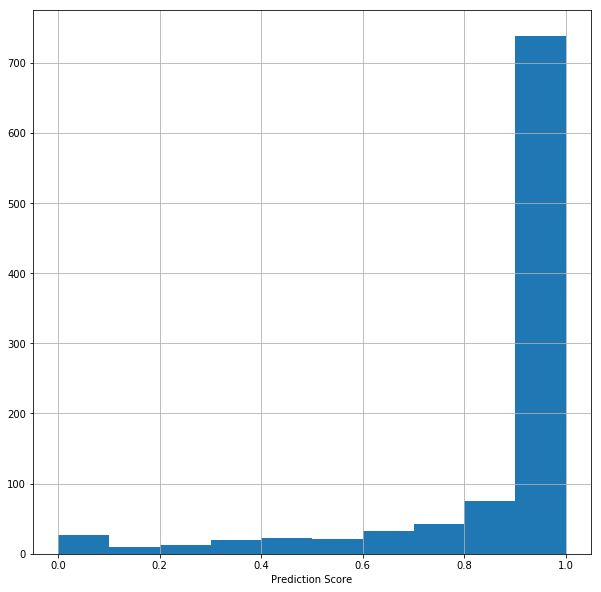

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='Dress'].label_class_score.hist(ax=ax)

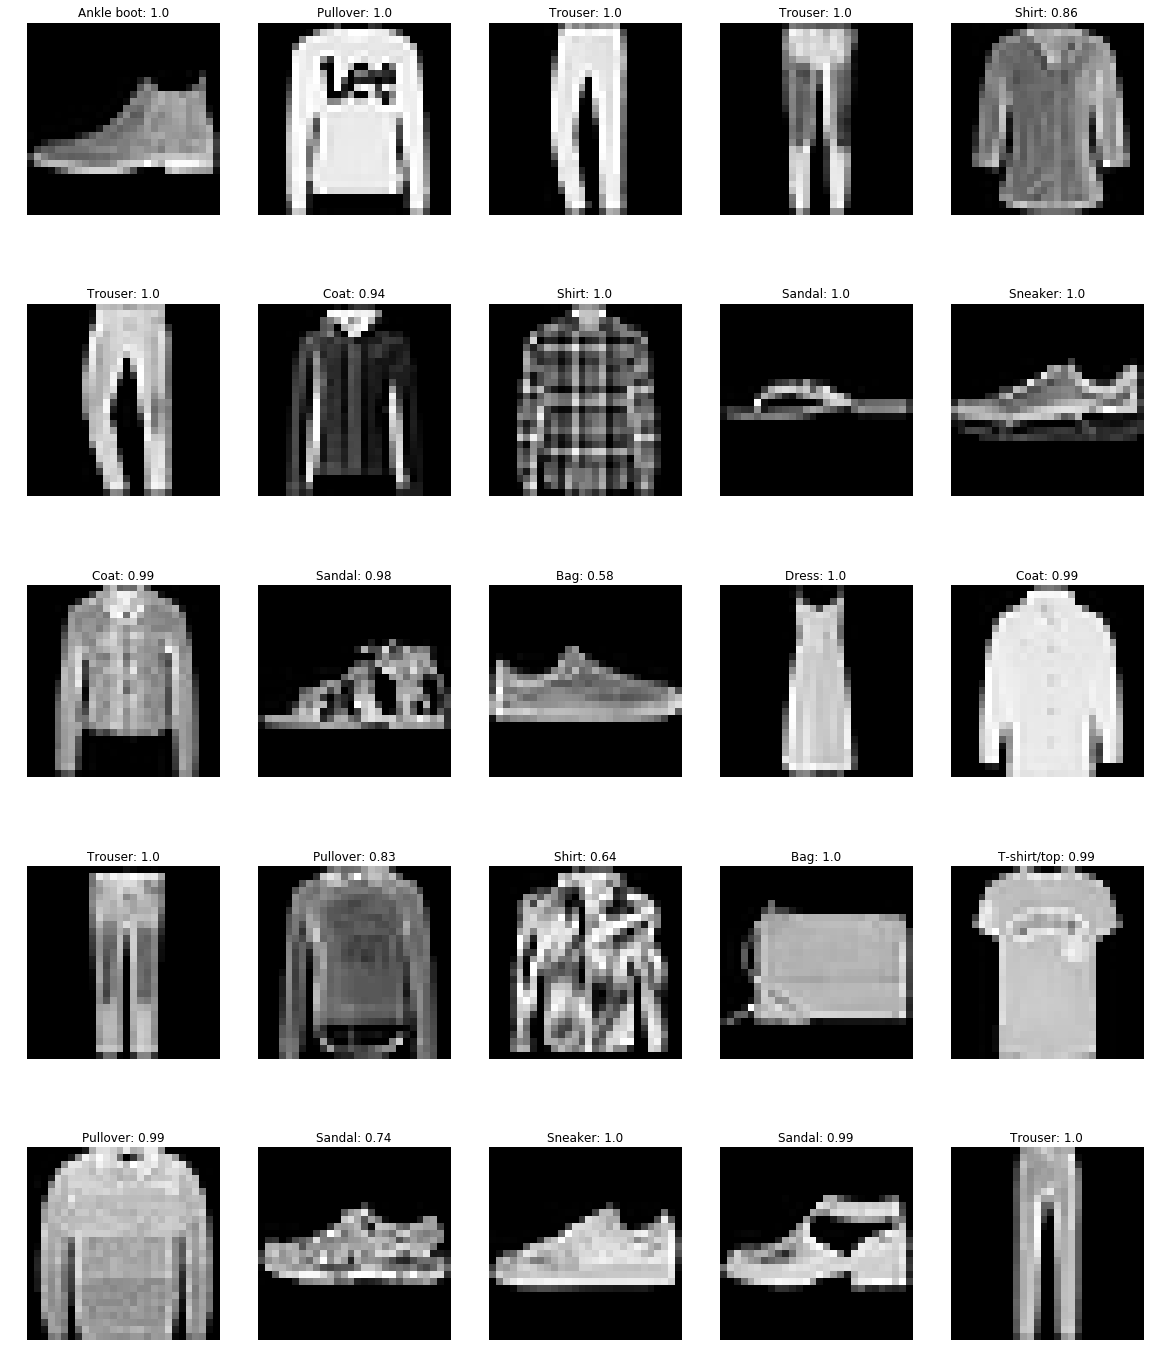

In [ ]:
plot_df_examples(df.iloc[:25])

### Basic Metrics

In [ ]:
get_precision(df, 'Dress')

88.71

In [ ]:
get_recall(df, 'Dress')

91.9

In [ ]:
get_rec_prec(df)

class_name  recall  precision
0  T-shirt/top    86.0      88.11
1      Trouser    99.3      96.88
2     Pullover    82.4      90.75
3        Dress    91.9      88.71
4         Coat    87.6      83.59
5       Sandal    97.6      98.79
6        Shirt    74.7      74.70
7      Sneaker    97.4      95.12
8          Bag    98.4      98.11
9   Ankle boot    96.6      97.38

In [ ]:
get_accuracy(df)

91.19

### False Positives


In [ ]:
fp = get_false_positives(df, label_class_name='Shirt')

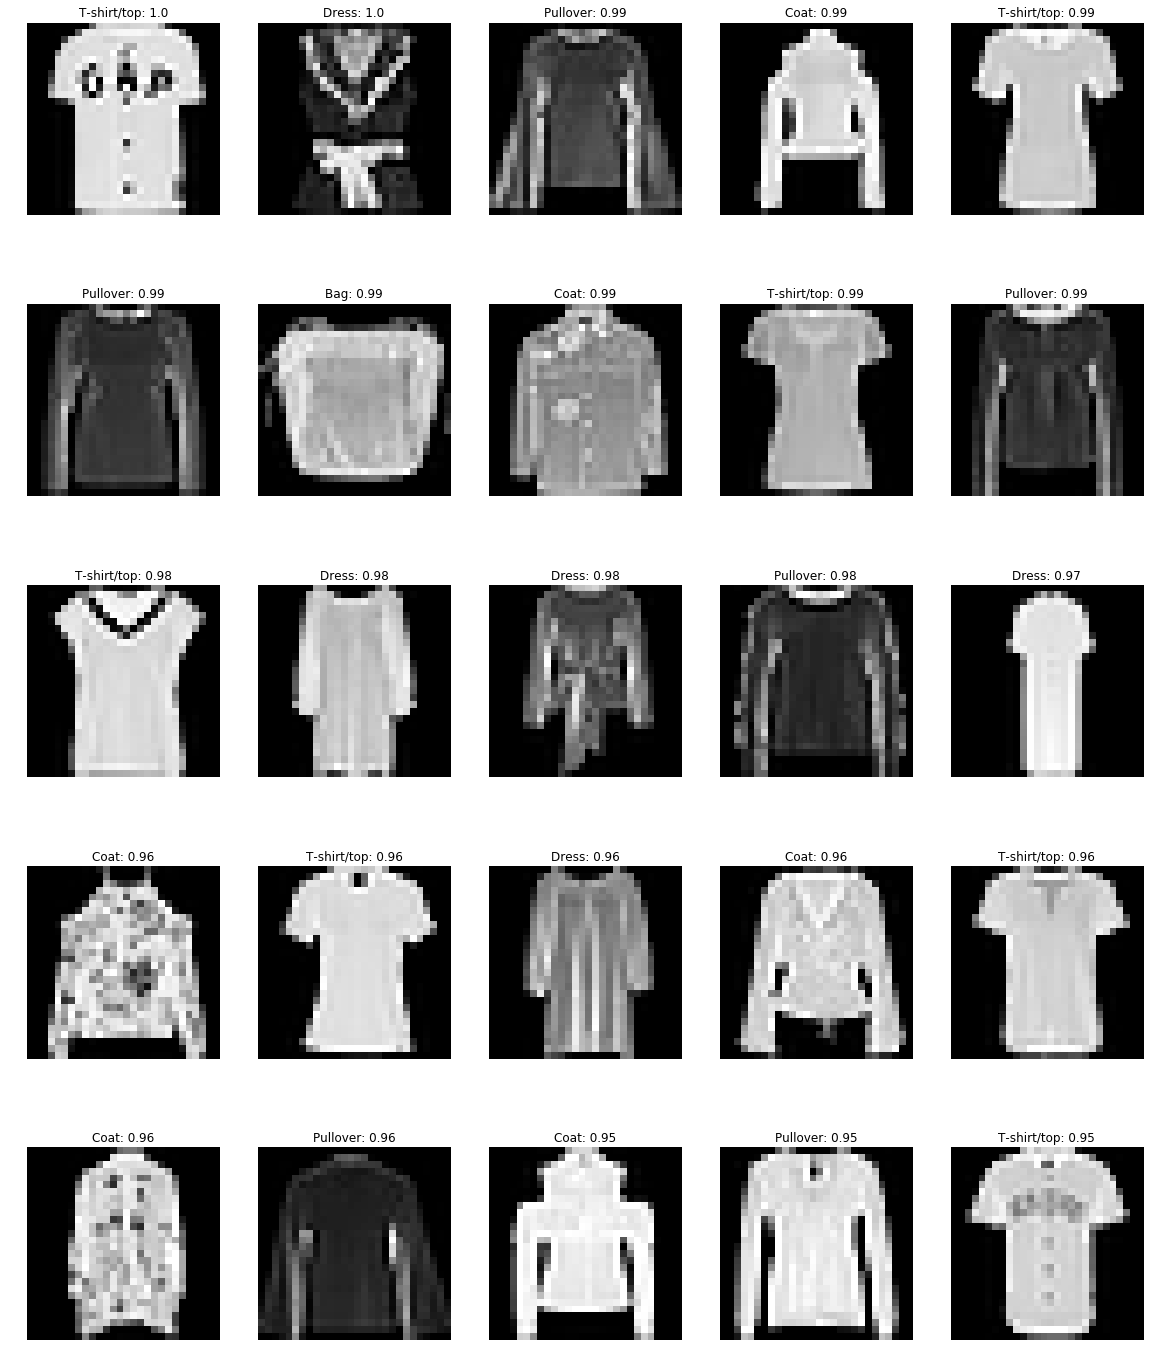

In [ ]:
plot_df_examples(fp)

In [ ]:
fp = get_false_positives(df, label_class_name='Shirt', predicted_class_name='Pullover')

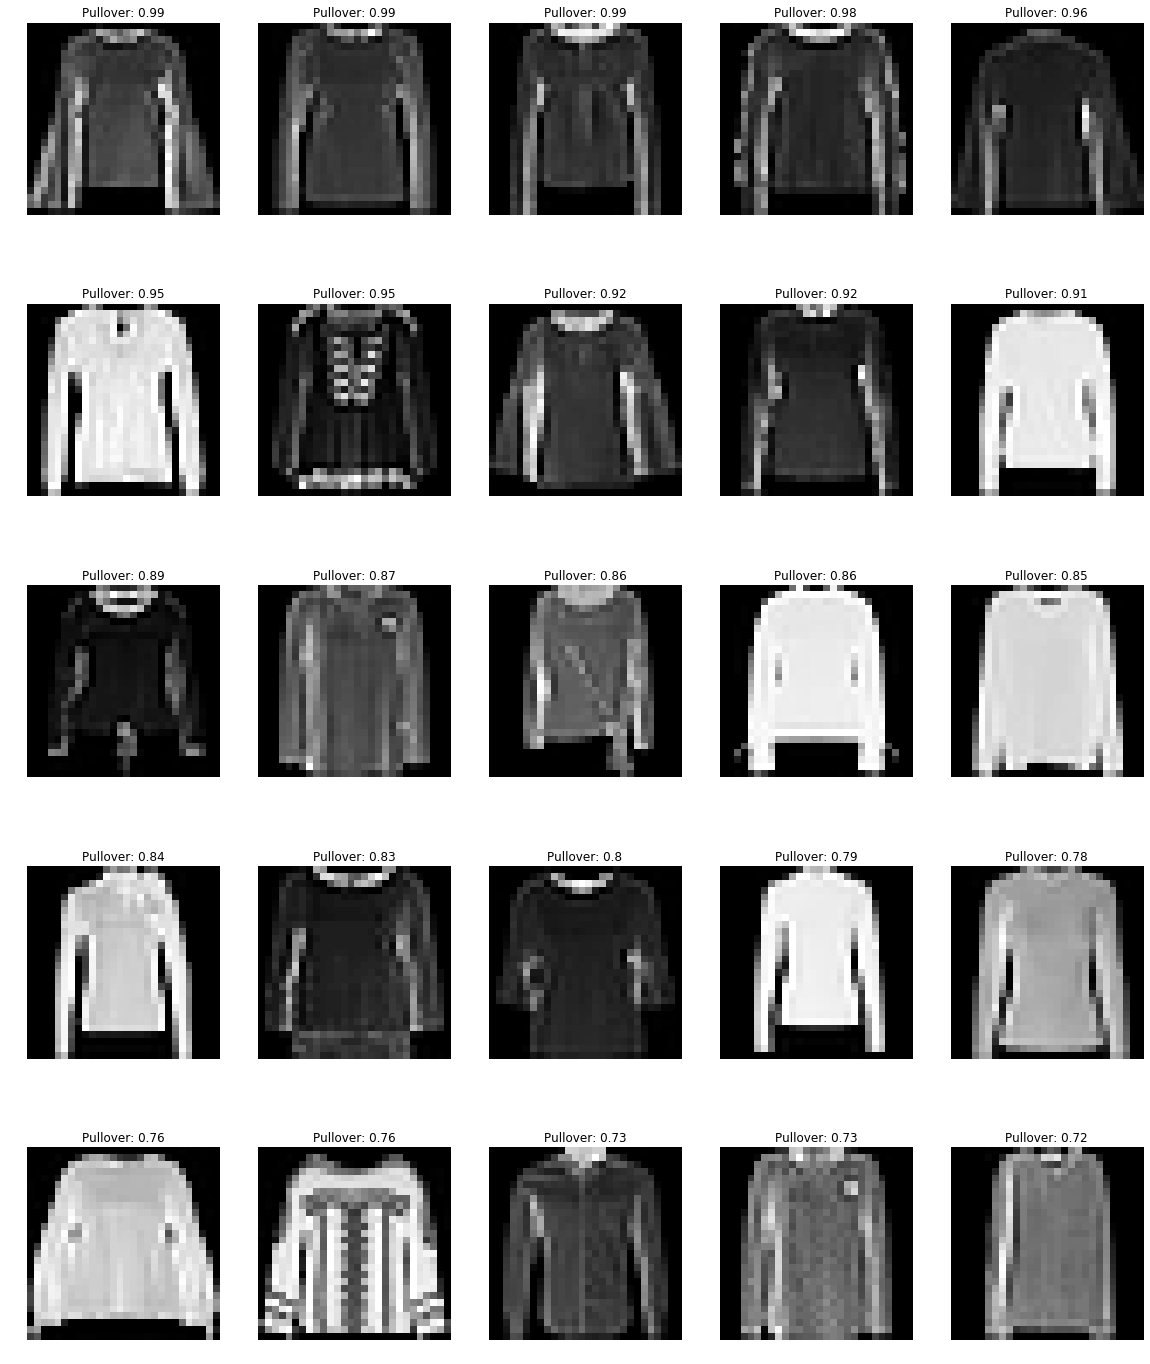

In [ ]:
plot_df_examples(fp)

### Confusion Matrix

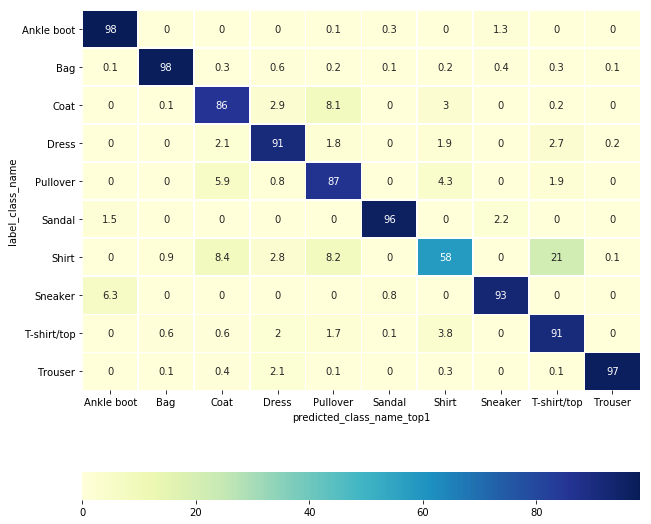

In [ ]:
plot_coocurance_matrix(df, use_log=False)

# Tensorboard visualizations


Tensorboar is great tool for visualizing neural networks, its' topology and for logging values during training and evaliation. It's by default prepared for networks build with tensorflow  framework. Now it's really easy to connect tensorboard with Pytorch

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
conv_neural_net_features = torch.nn.Sequential(*list(conv_neural_net.children())[:-1])

In [ ]:
conv_neural_net_features = conv_neural_net_features.eval().cuda()

In [ ]:
features = list()
labels = list()
images = list()
idx = 0
for img_batch, label_batch in tqdm.tqdm(valid_loader):
    img_features = conv_neural_net_features(img_batch.cuda())
    img_features = img_features.view(img_features.size(0), -1).cpu().detach().numpy().tolist()
    
    features += img_features
    labels += list(map(lambda l: valid_dataset.classes[l], label_batch.squeeze().detach().numpy().tolist()))
    images += img_batch.detach().numpy().tolist()
    
    idx += 1
    if idx > 15:
        break
    
features = torch.tensor(np.array(features))
images = torch.tensor(np.array(images))

  8%|▊         | 13/157 [00:00<00:05, 27.37it/s]


In [ ]:
writer = SummaryWriter()
writer.add_graph(conv_neural_net_features.cpu(), iter(valid_loader).__next__()[0])
writer.add_embedding(mat=features, metadata=labels, label_img=images)
writer.close()

In [ ]:
%tensorboard --logdir ./runs

Output hidden; open in https://colab.research.google.com to view.